In [32]:
import xarray as xr
import sys
import numpy as np
from scipy import interpolate
from pathlib import Path
import pandas as pd



# Now you can use args.cas_filename, args.gcm_name, args.input_dir, and args.output_dir in your script

mrso_climatology_file_path = "/home/lar/adjust_IFS/soil_moisture_clim/climatology_remapcon.nc"

# open cas-file, to be modified
file_cas=xr.open_dataset("cas2023090100.nc")

# remove time dimension
#file_cas = file_cas_original.isel(time=0)



# open file containing CC profiles and select by month and day
mrso_CC = xr.open_dataset(mrso_climatology_file_path)

# Define the soil1 coordinate
soil1_depths = [0.035, 0.175, 0.64, 1.945]

print("cas:")
print(file_cas)

print("Climatology:")
print(mrso_CC)




cas:
<xarray.Dataset>
Dimensions:     (time: 1, lat: 224, lon: 544, level: 98, soil1: 4, level1: 99,
                 bnds: 2)
Coordinates:
  * lat         (lat) float32 19.25 19.53 19.81 20.09 ... 81.36 81.64 81.92
  * level       (level) int32 40 41 42 43 44 45 46 ... 132 133 134 135 136 137
  * level1      (level1) int32 40 41 42 43 44 45 46 ... 133 134 135 136 137 138
  * lon         (lon) float32 -68.91 -68.62 -68.34 -68.06 ... 83.25 83.53 83.81
  * soil1       (soil1) float32 0.035 0.175 0.64 1.945
  * time        (time) datetime64[ns] 2023-09-01
Dimensions without coordinates: bnds
Data variables: (12/23)
    FIS         (time, lat, lon) float32 ...
    FR_LAND     (time, lat, lon) float32 ...
    FR_SEA_ICE  (time, lat, lon) float32 ...
    PS          (time, lat, lon) float32 ...
    QC          (time, level, lat, lon) float32 ...
    QI          (time, level, lat, lon) float32 ...
    ...          ...
    ak          (level1) float32 ...
    akm         (level) float32 ...
  

In [33]:
# Stack the data variables into a single DataArray with a new 'soil1' coordinate
mrso_stacked = xr.concat(
    [mrso_CC['swvl1'], mrso_CC['swvl2'], mrso_CC['swvl3'], mrso_CC['swvl4']],
    dim=pd.Index(soil1_depths, name='soil1')
)

# extract volume fraction of condensed water in soil pores
W_SO_REL = file_cas.W_SO_REL # ratio of volume fraction of soil moisture to pore volume [1]


# Rename the latitude and longitude coordinates
#mrso_stacked = mrso_stacked.rename({'latitude': 'lat', 'longitude': 'lon'})

# Reassign lat and lon coordinates in mrso_regridded to match W_SO_REL#
#mrso_stacked = mrso_stacked.assign_coords(lat=W_SO_REL['lat'], lon=W_SO_REL['lon'])


# Convert 'soil1' coordinate in mrso_regridded to float32
mrso_stacked = mrso_stacked.assign_coords(soil1=mrso_stacked['soil1'].astype('float32'))

mrso_stacked_rel = mrso_stacked / 0.472

# Reassign the 'soil1' coordinate to exactly match W_SO_REL
#mrso_redimensioned = mrso_stacked.assign_coords(soil1=W_SO_REL['soil1'])





In [34]:
mrso_stacked_rel

<xarray.DataArray 'swvl1' (soil1: 4, lat: 224, lon: 544)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -68.91 -68.62 -68.34 -68.06 ... 83.25 83.53 83.81
  * lat      (lat) float32 19.25 19.53 19.81 20.09 ... 81.08 81.36 81.64 81.92
  * soil1    (soil1) float32 0.035 0.175 0.64 1.945

In [35]:
W_SO_REL

<xarray.DataArray 'W_SO_REL' (time: 1, soil1: 4, lat: 224, lon: 544)>
[487424 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 19.25 19.53 19.81 20.09 ... 81.08 81.36 81.64 81.92
  * lon      (lon) float32 -68.91 -68.62 -68.34 -68.06 ... 83.25 83.53 83.81
  * soil1    (soil1) float32 0.035 0.175 0.64 1.945
  * time     (time) datetime64[ns] 2023-09-01
Attributes:
    standard_name:  volume_fraction_of_condensed_water_in_soil_pores
    long_name:      ratio of volume fraction of soil moisture to pore volume
    units:          1
    comment:        W_SO_REL=VW_SO/0.472

In [36]:


#===========================================================================
#                            save output
#===========================================================================


file_cas_new = xr.open_dataset("cas2023090100.nc")
condition = np.isfinite(mrso_stacked_rel) & (mrso_stacked_rel > 0)
 

file_cas_new['W_SO_REL'] = xr.where(condition, mrso_stacked_rel, W_SO_REL)





file_cas_new

<xarray.Dataset>
Dimensions:     (time: 1, lat: 224, lon: 544, level: 98, soil1: 4, level1: 99,
                 bnds: 2)
Coordinates:
  * lat         (lat) float32 19.25 19.53 19.81 20.09 ... 81.36 81.64 81.92
  * level       (level) int32 40 41 42 43 44 45 46 ... 132 133 134 135 136 137
  * level1      (level1) int32 40 41 42 43 44 45 46 ... 133 134 135 136 137 138
  * lon         (lon) float32 -68.91 -68.62 -68.34 -68.06 ... 83.25 83.53 83.81
  * soil1       (soil1) float32 0.035 0.175 0.64 1.945
  * time        (time) datetime64[ns] 2023-09-01
Dimensions without coordinates: bnds
Data variables: (12/23)
    FIS         (time, lat, lon) float32 ...
    FR_LAND     (time, lat, lon) float32 ...
    FR_SEA_ICE  (time, lat, lon) float32 ...
    PS          (time, lat, lon) float32 ...
    QC          (time, level, lat, lon) float32 ...
    QI          (time, level, lat, lon) float32 ...
    ...          ...
    ak          (level1) float32 ...
    akm         (level) float32 ...
    bk          (level1) float32 ...
    bkm         (level) float32 ...
    soil1_bnds  (soil1, bnds) float32 ...
    time_bnds   (time, bnds) datetime64[ns] ...
Attributes:
    institution:     ECMWF
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org
    source:          ERA5
    creation_date:   2023-12-01 03:21:33
    history:         Fri Dec  1 03:22:00 2023: /sw/spack-levante/nco-5.0.6-3x...
    NCO:             netCDF Operators version 5.0.6 (Homepage = http://nco.sf...

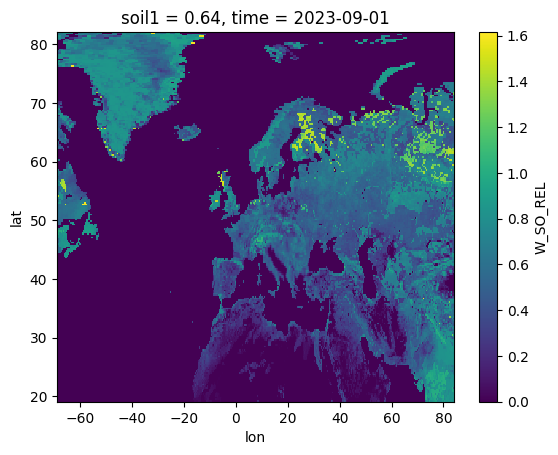

In [37]:
import matplotlib.pyplot as plt


#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
#axes = axes.flatten()


file_cas_new['W_SO_REL'].sel(soil1=0.64, method='nearest').plot(cmap='viridis')


#plt.tight_layout()
plt.show()

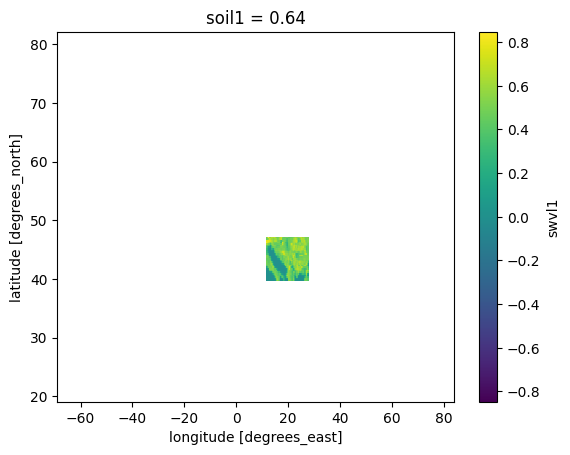

In [38]:
mrso_stacked_rel.sel(soil1=0.64, method='nearest').plot(cmap='viridis')

plt.show()

In [39]:
file_cas_new

<xarray.Dataset>
Dimensions:     (time: 1, lat: 224, lon: 544, level: 98, soil1: 4, level1: 99,
                 bnds: 2)
Coordinates:
  * lat         (lat) float32 19.25 19.53 19.81 20.09 ... 81.36 81.64 81.92
  * level       (level) int32 40 41 42 43 44 45 46 ... 132 133 134 135 136 137
  * level1      (level1) int32 40 41 42 43 44 45 46 ... 133 134 135 136 137 138
  * lon         (lon) float32 -68.91 -68.62 -68.34 -68.06 ... 83.25 83.53 83.81
  * soil1       (soil1) float32 0.035 0.175 0.64 1.945
  * time        (time) datetime64[ns] 2023-09-01
Dimensions without coordinates: bnds
Data variables: (12/23)
    FIS         (time, lat, lon) float32 ...
    FR_LAND     (time, lat, lon) float32 ...
    FR_SEA_ICE  (time, lat, lon) float32 ...
    PS          (time, lat, lon) float32 ...
    QC          (time, level, lat, lon) float32 ...
    QI          (time, level, lat, lon) float32 ...
    ...          ...
    ak          (level1) float32 ...
    akm         (level) float32 ...
    bk          (level1) float32 ...
    bkm         (level) float32 ...
    soil1_bnds  (soil1, bnds) float32 ...
    time_bnds   (time, bnds) datetime64[ns] ...
Attributes:
    institution:     ECMWF
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org
    source:          ERA5
    creation_date:   2023-12-01 03:21:33
    history:         Fri Dec  1 03:22:00 2023: /sw/spack-levante/nco-5.0.6-3x...
    NCO:             netCDF Operators version 5.0.6 (Homepage = http://nco.sf...